#### 필요한 라이브러리 및 데이터 불러오기 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt 
#import plotly.graph_objects as go
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

labelencoder = LabelEncoder()
%matplotlib inline


froot='https://raw.githubusercontent.com/JiwooKimm/Personal_Projects/master/Forecaster_Airpollutant_Seoul/datasets/'
fname= 'Measurement_summary.csv'

data= pd.read_csv(froot+fname)
data.head()

,Measurement date,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 01:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.058,0.002,1.2,71.0,59.0
2,2017-01-01 02:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,59.0
3,2017-01-01 03:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,58.0
4,2017-01-01 04:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.051,0.002,1.2,69.0,61.0


#### 데이터 확인 및 결측치 처리 

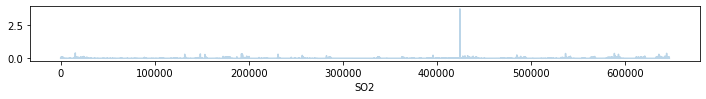

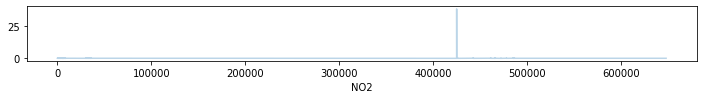

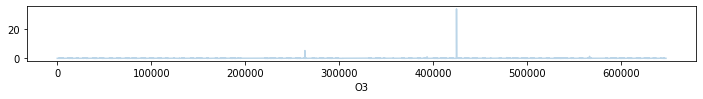

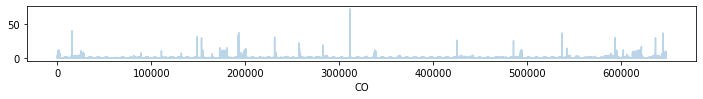

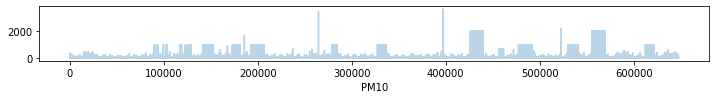

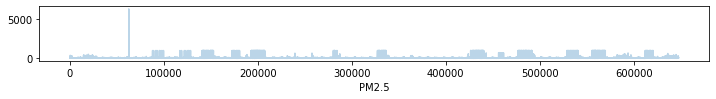

In [2]:
# 데이터 확인 

for i in range(6):
  plt.figure(figsize=(12,1))
  d= data.iloc[:,5+i]
  d[d >= 0 ].plot(alpha=0.3)
  plt.xlabel(str(data.columns[5+i]))
  plt.show()

In [3]:
#check Null
data.describe() 

,Station code,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
count,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000
mean,113.000221,37.553484,126.989340,-0.001795,0.022519,0.017979,0.509197,43.708051,25.411995
std,7.211315,0.053273,0.078790,0.078832,0.115153,0.099308,0.405319,71.137342,43.924595
min,101.000000,37.452357,126.835151,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,107.000000,37.517528,126.927102,0.003000,0.016000,0.008000,0.300000,22.000000,11.000000
50%,113.000000,37.544962,127.004850,0.004000,0.025000,0.021000,0.500000,35.000000,19.000000
75%,119.000000,37.584848,127.047470,0.005000,0.038000,0.034000,0.600000,53.000000,31.000000
max,125.000000,37.658774,127.136792,3.736000,38.445000,33.600000,71.700000,3586.000000,6256.000000


In [4]:
#check num of NaN
data.isna().sum()


Measurement date    0
Station code        0
Address             0
Latitude            0
Longitude           0
SO2                 0
NO2                 0
O3                  0
CO                  0
PM10                0
PM2.5               0
dtype: int64

In [5]:
# check filled missing values
from collections import Counter
# missing=[]
for i in range(6):
  
  col= data.iloc[:, i+5]
  print(data.columns[i+5], Counter(col[col < 0]))
  print()
  missing= col.loc[(col<0)]
  data= data.drop(missing.index, axis=0)

SO2 Counter({-1.0: 3976})

NO2 Counter({-1.0: 48})

O3 Counter({-1.0: 269})

CO Counter({-1.0: 236})

PM10 Counter({-1.0: 311})

PM2.5 Counter({-1.0: 152})



In [6]:
# filled value 없어졌는지 확인 
data.describe() 

,Station code,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
count,642519.000000,642519.000000,642519.000000,642519.000000,642519.000000,642519.000000,642519.000000,642519.000000,642519.000000
mean,113.018281,37.553447,126.989432,0.004368,0.028617,0.024399,0.518420,43.981787,25.569000
std,7.211230,0.053337,0.078862,0.007616,0.084183,0.057882,0.381877,71.210175,43.891884
min,101.000000,37.452357,126.835151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,107.000000,37.517528,126.927102,0.003000,0.016000,0.009000,0.300000,22.000000,11.000000
50%,113.000000,37.544962,127.004850,0.004000,0.025000,0.021000,0.500000,35.000000,19.000000
75%,119.000000,37.584848,127.047470,0.005000,0.038000,0.035000,0.600000,53.000000,31.000000
max,125.000000,37.658774,127.136792,3.736000,38.445000,33.600000,71.700000,3586.000000,6256.000000


In [7]:
data.head(10)

,Measurement date,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 01:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.058,0.002,1.2,71.0,59.0
2,2017-01-01 02:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,59.0
3,2017-01-01 03:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,58.0
4,2017-01-01 04:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.051,0.002,1.2,69.0,61.0
5,2017-01-01 05:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.046,0.002,1.1,70.0,61.0
6,2017-01-01 06:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.049,0.002,1.1,66.0,57.0
7,2017-01-01 07:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.045,0.002,1.0,71.0,60.0
8,2017-01-01 08:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.047,0.002,1.1,72.0,60.0
9,2017-01-01 09:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.047,0.002,1.1,74.0,63.0


In [8]:
# 총 지역구 수 
print(data['Station code'].unique())
print(len(data['Station code'].unique()))

date_count= data['Measurement date'].groupby(data['Station code']).count()

print(date_count)



[101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125]
25
Station code
101    25862
102    25868
103    25698
104    25407
105    25196
106    25262
107    25797
108    25615
109    25373
110    25645
111    25802
112    25839
113    25772
114    25891
115    25891
116    25755
117    25825
118    25889
119    25865
120    25756
121    25342
122    25772
123    25681
124    25841
125    25875
Name: Measurement date, dtype: int64


##### 지역구 데이터 분리



In [9]:
def prep_data(data,gu):
  df= data[data['Station code'] == gu]
  df.drop(['Station code', 'Address','Latitude','Longitude'], axis=1, inplace= True)
  df.set_index('Measurement date', drop='True', inplace=True)
  df= df[['SO2',	'NO2',	'CO',	'PM10',	'PM2.5',	'O3']]
  return df

gu= 101 #종로
df= prep_data(data,gu)

df.head(2)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,SO2,NO2,CO,PM10,PM2.5,O3
Measurement date,,,,,,
2017-01-01 00:00,0.004,0.059,1.2,73.0,57.0,0.002
2017-01-01 01:00,0.004,0.058,1.2,71.0,59.0,0.002


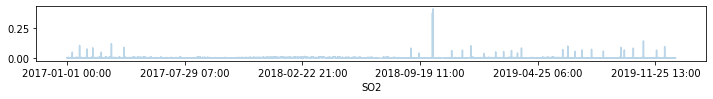

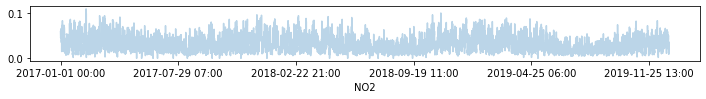

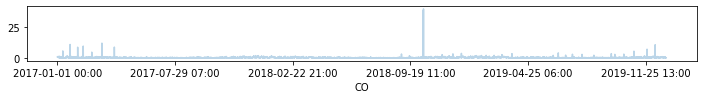

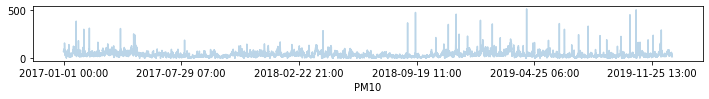

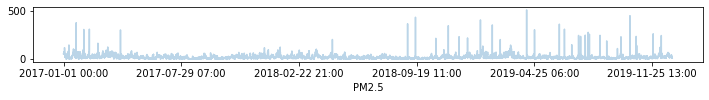

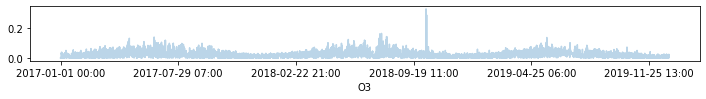

                SO2           NO2            CO          PM10        PM2.5  \
count  25862.000000  25862.000000  25862.000000  25862.000000  25862.00000   
mean       0.004371      0.031642      0.584688     38.024515     22.88833   
std        0.004685      0.016603      0.473824     27.410630     19.99824   
min        0.000000      0.000000      0.000000      0.000000      0.00000   
25%        0.003000      0.019000      0.400000     21.000000     11.00000   
50%        0.004000      0.028000      0.500000     32.000000     18.00000   
75%        0.005000      0.042000      0.700000     48.000000     29.00000   
max        0.406000      0.109000     40.000000    516.000000    513.00000   

                 O3  
count  25862.000000  
mean       0.024622  
std        0.019101  
min        0.000000  
25%        0.009000  
50%        0.022000  
75%        0.035000  
max        0.325000  


In [10]:
# 제대로 전처리가 되었는지 재확인 
for i in range(6):
  plt.figure(figsize=(12,1))
  d= df.iloc[:,i]
  d[d >= 0].plot(alpha=0.3)
  plt.xlabel(str(df.columns[i]))
  plt.show()
print(df.describe())  

In [11]:
# # print(df['Measurement date'].dtypes)

# import datetime as dt

# for stringT in df['Measurement date']:
  
#   s2t= dt.datetime.strptime(stringT, '%Y-%m-%d %H:%M')
#   # print(s2t)
#   df['Measurement date'].loc[stringT]= s2t
# print(df['Measurement date'].dtypes)

#### 학습 - 검증 데이터 분리 & 정규화


In [12]:
from sklearn.preprocessing import MinMaxScaler

# 7일간의 데이터가 입력으로 들어가고 batch size는 임의로 지정
seq_length = 7
batch = 100

# 전체 데이터의 70% 학습, 30% 테스트에 사용 
train_size = int(df.shape[0]*0.7)
train_set = df[0:train_size]  
test_set = df[(train_size - seq_length) : ]


## Data Normalization (0~1) :: 데이터의 단위가 모두 다르기 때문에 꼭! 해주어야함 
# Input scale
mM_x = MinMaxScaler()
mM_x.fit(train_set.iloc[:, :-1])

train_set.iloc[:, :-1] = mM_x.transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1] = mM_x.transform(test_set.iloc[:, :-1])

# Output scale
mM_y = MinMaxScaler()
mM_y.fit(train_set.iloc[:, [-1]])

train_set.iloc[:, -1] = mM_y.transform(train_set.iloc[:, [-1]])
test_set.iloc[:, -1] = mM_y.transform(test_set.iloc[:, [-1]])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [13]:
# 이상치 제거 
for col in df.columns: 
  outliers= df[df[col] > 1].index
  df.drop(outliers, axis=0, inplace=True)

df.describe()

,SO2,NO2,CO,PM10,PM2.5,O3
count,25852.000000,25852.000000,25852.000000,25852.000000,25852.000000,25852.000000
mean,0.010767,0.290333,0.014619,0.079271,0.052291,0.075754
std,0.011541,0.152334,0.011848,0.056313,0.044809,0.058776
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.007389,0.174312,0.010000,0.043841,0.025172,0.027692
50%,0.009852,0.256881,0.012500,0.066806,0.041190,0.067692
75%,0.012315,0.385321,0.017500,0.100209,0.066362,0.107692
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 데이터셋 생성 및 텐서 형태로 변환
- 파이토치에서는 3D 텐서 입력 받음!
  - `torch.FloatTensor`를 사용하여 *np.arrary* 형태에서 *tensor* 형태로 바꿔줘야함.

- 파이토치에서는 데이터를 좀 더 쉽게 다룰 수 있는 유용한 도구로 `Dataset`과 `DataLoader`를 제공

  - 미니 배치 학습, 데이터 셔플, 병렬 처리 등 간단히 수행 ㄱㄴ 

  - 기본적인 사용 방법은 Dataset을 정의하고 -> DataLoader에 전달

In [14]:
import torch
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)

#### LSTM 모델 정의

<img src="https://miro.medium.com/max/1156/1*laH0_xXEkFE0lKJu54gkFQ.png" width=500 align="center">

*initial setting*
- input size: 6 
- hidden size: 10 
- output size: 1
- learning rate: 0.02


In [15]:
# 설정값
data_dim = 6
hidden_dim = 12
output_dim = 1 
learning_rate = 0.02
nb_epochs = 100


class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

#### 학습 
**early stopping** epoch 지나도 학습의 효과가 보이지 않으면 중단!



In [16]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            
            # seq별 hidden state reset
            model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train)                    
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopped')
                
                break
            
    return model.eval(), train_hist

In [17]:
# 모델 학습
net = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 10, patience = 10)

Epoch: 0000 train loss : 0.0023
Epoch: 0010 train loss : 0.0004
Epoch: 0020 train loss : 0.0004
Epoch: 0030 train loss : 0.0004
Epoch: 0040 train loss : 0.0004
Epoch: 0050 train loss : 0.0004
Epoch: 0060 train loss : 0.0004

 Early Stopped


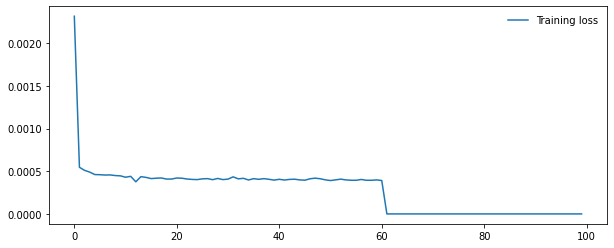

In [18]:

# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend(frameon=False)
# plt.xlim(0,100)
plt.show()

#### 모델 저장


In [19]:
from google.colab import files
# 모델 저장    
PATH = "./Airpollution_Seoul_LSTM_.pth"
torch.save(model.state_dict(), PATH)
files.download(PATH)

# 불러오기
model = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Net(
  (lstm): LSTM(6, 12, batch_first=True)
  (fc): Linear(in_features=12, out_features=1, bias=True)
)

#### 평가

In [20]:
print(test_set.index[0])
print(test_set.index[-1])

2019-01-26 14:00
2019-12-31 23:00


In [21]:
# 예측 테스트
with torch.no_grad(): 
    pred = []
    for pr in range(len(testX_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = mM_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = mM_y.inverse_transform(testY_tensor)

def scoring(true, pred):
  r2= round(metrics.r2_score(true, pred)*100,3)
  corr= round(np.corrcoef(true, pred)[0,1],3) 
  mape= round(metrics.mean_absolute_percentage_error(true, pred)*100,3)
  rmse= round(metrics.mean_squared_error(true, pred, squared=False),3)
  mae= np.mean(np.abs(true-pred))
  
  df= pd.DataFrame({ "R2":   r2,
                     "Corr": corr,
                     "RMSE": rmse,
                     "MAPE": mape,
                     "MAE": mae},
                     
                    index=[0])
  return df

scoring(pred_inverse, testY_inverse)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,R2,Corr,RMSE,MAPE,MAE
0,90.153,NaN,0.005,21.748,0.003517


In [28]:
print(pred_inverse)
print(testY_inverse)


[[0.04349951]
 [0.03045478]
 [0.05330641]
 ...
 [0.01625831]
 [0.02374088]
 [0.01286223]]
[[0.022]
 [0.017]
 [0.009]
 ...
 [0.021]
 [0.014]
 [0.005]]


7766


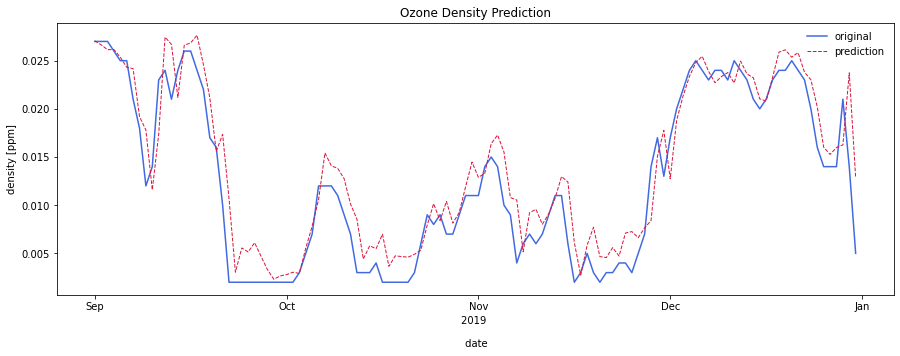

In [36]:
numo3= test_set.shape[0]
print(numo3)
# tickname=(np.arange(0,5)*round(numo3/4))
tickname=np.arange(0,5)*(120/4)

# ticklabels=np.array(['Jan','Mar','Jun','Sep','Dec'])
ticklabels=np.array(['Sep','Oct','Nov','Dec','Jan'])

plt.figure(figsize=(15,5))
# plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'original',  c='royalblue')
# plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'prediction', c='crimson',  ls='--', lw=1)
plt.plot(testY_inverse[-120:], label = 'original',  c='royalblue')
plt.plot(pred_inverse[-120:], label = 'prediction', c='crimson',  ls='--', lw=1)


plt.title('Ozone Density Prediction')
plt.xlabel('2019 \n\n date')
plt.ylabel('density [ppm]')
plt.legend(frameon=False)
plt.xticks(ticks=tickname,labels=ticklabels)


plt.savefig('./AirPollution_Seoul_LSTM.eps')

plt.show()